In [1]:

from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("marketing_campaign.csv", sep="\t")
df.drop(columns=["ID", "Dt_Customer", "Z_CostContact", "Z_Revenue"], inplace=True)
df.dropna(inplace=True)
numerical_df = df.select_dtypes(include=["int64", "float64"])
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,1957,Graduation,Single,58138.0,0,0,58,635,88,546,...,10,4,7,0,0,0,0,0,0,1
1,1954,Graduation,Single,46344.0,1,1,38,11,1,6,...,1,2,5,0,0,0,0,0,0,0
2,1965,Graduation,Together,71613.0,0,0,26,426,49,127,...,2,10,4,0,0,0,0,0,0,0
3,1984,Graduation,Together,26646.0,1,0,26,11,4,20,...,0,4,6,0,0,0,0,0,0,0
4,1981,PhD,Married,58293.0,1,0,94,173,43,118,...,3,6,5,0,0,0,0,0,0,0


In [2]:

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_df)

# Optional: Reduce dimensionality for better DBSCAN and visualization
pca = PCA(n_components=10)  # retain ~90% variance (can adjust)
reduced_data = pca.fit_transform(scaled_data)

C:\Users\skull\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\skull\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\skull\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\skull\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  

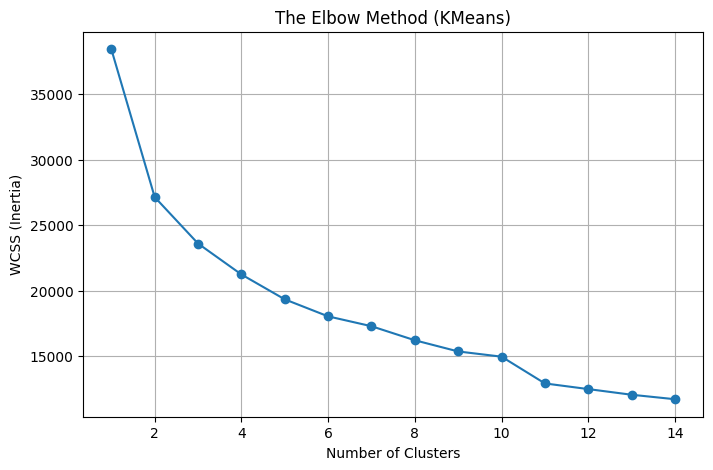

In [3]:
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(reduced_data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 15), wcss, marker='o')
plt.title('The Elbow Method (KMeans)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Inertia)')
plt.grid()
plt.show()

In [4]:
kmeans = KMeans(n_clusters=4, random_state=42)
y_kmeans = kmeans.fit_predict(reduced_data)

dbscan = DBSCAN(eps=1.1, min_samples=4)
y_dbscan = dbscan.fit_predict(reduced_data)

hc = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
y_hc = hc.fit_predict(reduced_data)

In [5]:
models = ['KMeans', 'DBSCAN', 'Hierarchical']
outputs = [y_kmeans, y_dbscan, y_hc]

silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for output in outputs:
    if len(set(output)) > 1:
        silhouette_scores.append(metrics.silhouette_score(reduced_data, output))
        davies_bouldin_scores.append(metrics.davies_bouldin_score(reduced_data, output))
        calinski_harabasz_scores.append(metrics.calinski_harabasz_score(reduced_data, output))
    else:
        silhouette_scores.append(None)
        davies_bouldin_scores.append(None)
        calinski_harabasz_scores.append(None)

scores_df = pd.DataFrame({
    'Model': models,
    'Silhouette Score': silhouette_scores,
    'Davies-Bouldin Index': davies_bouldin_scores,
    'Calinski-Harabasz Index': calinski_harabasz_scores
})

print("\n🔍 Cluster Evaluation Scores:\n")
print(scores_df)


🔍 Cluster Evaluation Scores:

          Model  Silhouette Score  Davies-Bouldin Index  \
0        KMeans          0.251720              1.571478   
1        DBSCAN         -0.217511              1.459678   
2  Hierarchical          0.226596              1.577540   

   Calinski-Harabasz Index  
0               596.499959  
1                31.971613  
2               498.059047  


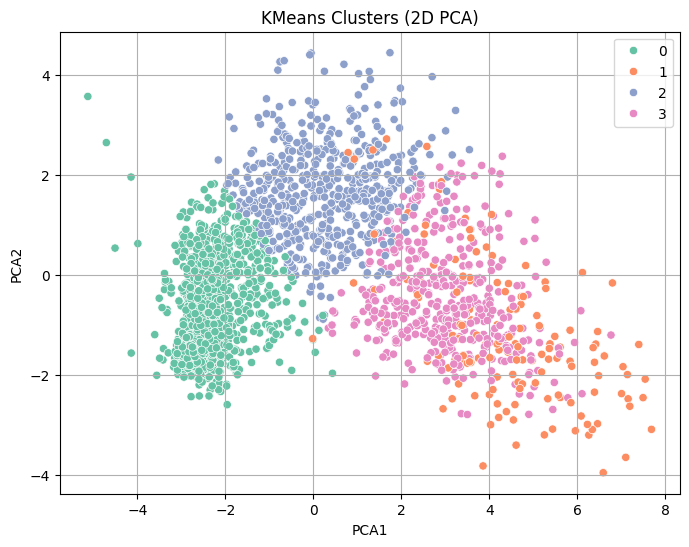

In [6]:
pca_2d = PCA(n_components=2)
pca_data = pca_2d.fit_transform(reduced_data)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=y_kmeans, palette='Set2')
plt.title('KMeans Clusters (2D PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid()
plt.show()